# Kámen - nůžky - papír s využitím MobileNetV2

### Vytvořeno jako součást DP na FIM UHK, Bc. Štěpán Záliš

### V praktické části diplomové práce byl vytvořen model pro rozpoznávání gest ze známé hry kámen - nůžky - papír za pomocí modelu MobileNetV2

_Vybrané skripty byly inpirovány ze článku [Getting started with TensorFlow 2.0](https://medium.com/@himanshurawlani/getting-started-with-tensorflow-2-0-faf5428febae)_

## Import závislostí

In [7]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import os
import datetime

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)


/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version: 3.10.10
Tensorflow version: 2.13.0


## Načtení Tenserboard

Tenserboard slouží pro debug trénování modelů

In [529]:
# Načtení TensorBoard 
# %reload_ext tensorboard
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [8]:
# Smazání logů z předchozích spuštění
!rm -rf ./logs/

## Načtení datasetu

Dataset se stáhne z [TensorFlow Datasets](https://github.com/tensorflow/datasets) pomocí Builderu [tfds.core.DatasetBuilder]. Dataset je rozdělen na trénovací, testovací část. 


Všechny dostupné datasety lze najít pomocí 

```python
tfds.list_builders()
```

In [9]:
DATASET_NAME = 'rock_paper_scissors'

(dataset_train_raw, dataset_test_raw), dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir='tmp',
    with_info=True,
    as_supervised=True,
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
)

Zobrazení informaci o počtu obrázků v jednotlivých složkách.

In [10]:
print('Raw train dataset:', dataset_train_raw)
print('Raw train dataset size:', len(list(dataset_train_raw)), '\n')

print('Raw test dataset:', dataset_test_raw)
print('Raw test dataset size:', len(list(dataset_test_raw)), '\n')

Raw train dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Raw train dataset size: 2520 

Raw test dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Raw test dataset size: 372 



Pro kompletní výpis informací lze použít následující kód:

In [11]:
dataset_info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_path='tmp/rock_paper_scissors/3.0.0',
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
)

In [12]:
NUM_TRAIN_EXAMPLES = dataset_info.splits['train'].num_examples
NUM_TEST_EXAMPLES = dataset_info.splits['test'].num_examples
NUM_CLASSES = dataset_info.features['label'].num_classes

print('Number of TRAIN examples:', NUM_TRAIN_EXAMPLES)
print('Number of TEST examples:', NUM_TEST_EXAMPLES)
print('Number of LABEL classes:', NUM_CLASSES)

Number of TRAIN examples: 2520
Number of TEST examples: 372
Number of LABEL classes: 3


In [13]:
INPUT_IMG_SIZE_ORIGINAL = dataset_info.features['image'].shape[0]
INPUT_IMG_SHAPE_ORIGINAL = dataset_info.features['image'].shape

# Pro trénování použijeme velikost [128, 128] pixelů.
INPUT_IMG_SIZE_REDUCED = 128

INPUT_IMG_SHAPE_REDUCED = (
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SHAPE_ORIGINAL[2]
)

INPUT_IMG_SIZE = INPUT_IMG_SIZE_REDUCED
INPUT_IMG_SHAPE = INPUT_IMG_SHAPE_REDUCED

print('Input image shape (original):', INPUT_IMG_SHAPE_ORIGINAL)
print('\n')
print('Input image shape (reduced):', INPUT_IMG_SHAPE_REDUCED)

Input image shape (original): (300, 300, 3)


Input image shape (reduced): (128, 128, 3)


In [14]:
# Konverze z labelID do labelName
get_label_name = dataset_info.features['label'].int2str

print(get_label_name(0));
print(get_label_name(1));
print(get_label_name(2));

rock
paper
scissors


## Procházení datasetu

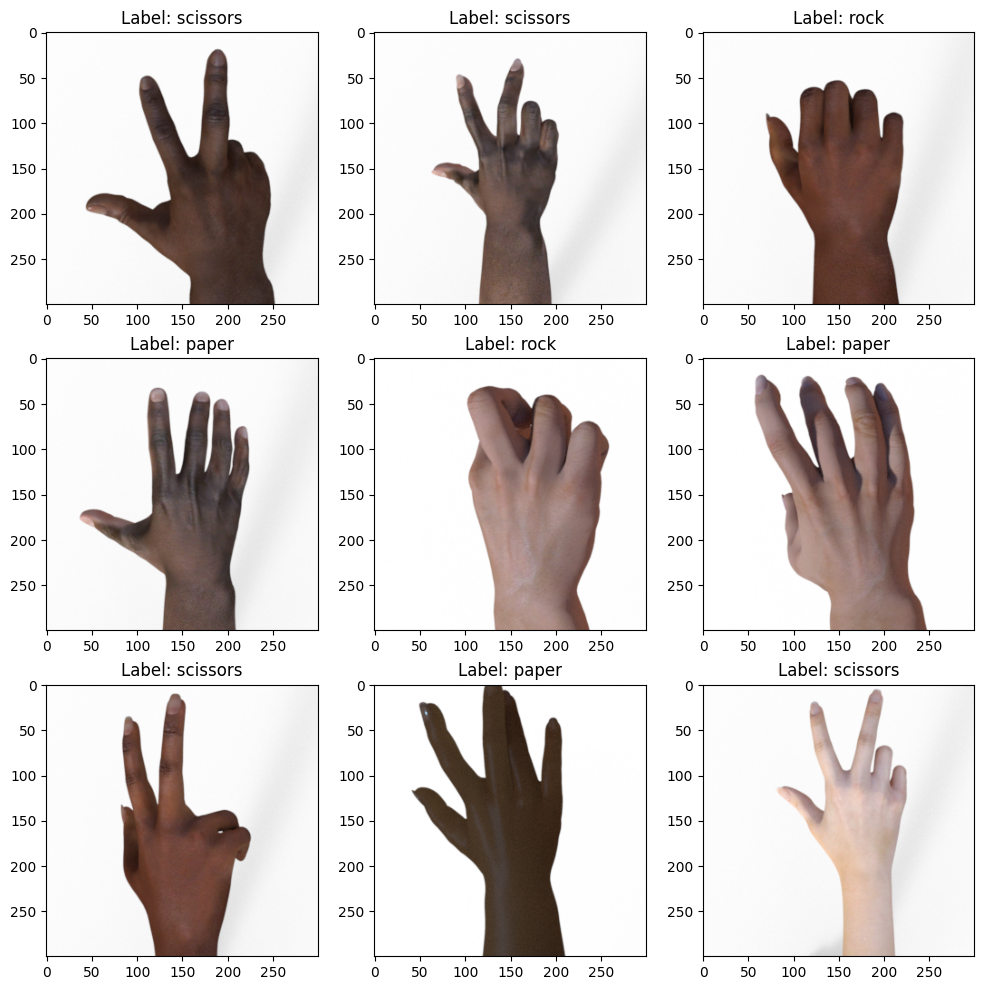

In [15]:
# Zobrazí náhled datasetu
def preview_dataset(dataset):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(9):
        (image, label) = features
        plot_index += 1
        plt.subplot(3, 3, plot_index)
       
        label = get_label_name(label.numpy())
        plt.title('Label: %s' % label)
        plt.imshow(image.numpy())

# Explore raw training dataset images.
preview_dataset(dataset_train_raw)        

## Předzpracování dat

In [5]:
def format_image(image, label):
    # Změna barvy na float32
    image = tf.cast(image, tf.float32)
    # Model MobileNet V2 pracuje s hodnotami od -1 do 1
    image = image / 255.
    # Změna velikosti obrázku na 128x128 pixelů
    image = tf.image.resize(image, [INPUT_IMG_SIZE, INPUT_IMG_SIZE])
    return image, label


dataset_train = dataset_train_raw.map(format_image)
dataset_test = dataset_test_raw.map(format_image)

NameError: name 'dataset_train_raw' is not defined

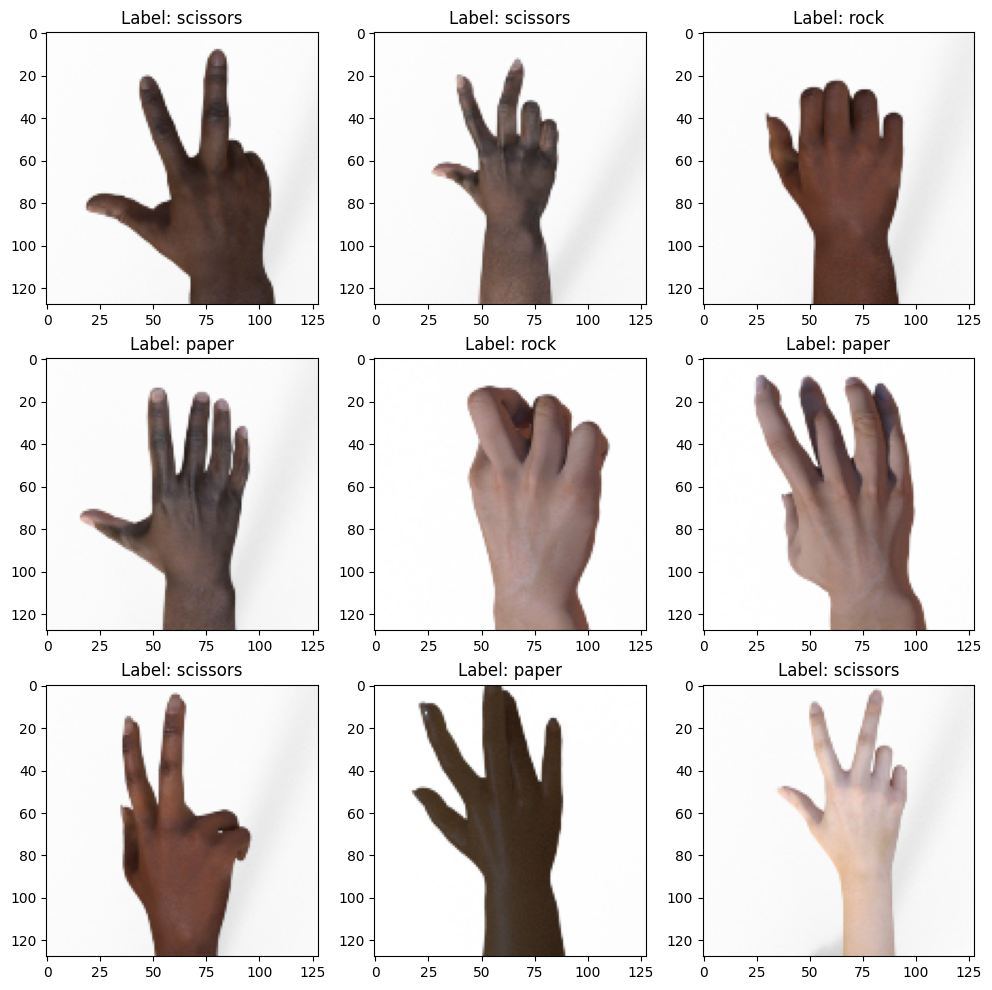

In [539]:
# Zobrazení upravených obrázků v datasetu 
preview_dataset(dataset_train)

## Úprava datasetu

Abychom zabránili přeučení na daném datasetu, pomocí následujících funkcí upravíme trénovací data. K tomu bude sloužít změna barvy a rotace. Jelikož všechny obrázky jsou na bílém pozadí, je vhodné barvy změnit, aby nebyl model citlivý na pozadí. Stejně tak jsou všechny obrázky s rukou ve vertikální poloze, takže je vhodné obrázky otočit, aby byl model invariantní vůči rotaci. 

Funkce byly přejaty z [Simple and efficient data augmentations using the Tensorfow tf.Data and Dataset API](https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/).

In [540]:
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

In [541]:
def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.6, upper=1.3)
    image = tf.image.random_brightness(image, 0.06)
    image = tf.image.random_contrast(image, lower=0.7, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image

In [542]:
def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Náhodná rotace o 90, 180 nebo 270 stupňů
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )

In [543]:
def augment_inversion(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.5:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image

In [544]:
def augment_zoom(image: tf.Tensor, min_zoom=0.8, max_zoom=1.0) -> tf.Tensor:
    image_width, image_height, image_colors = image.shape
    crop_size = (image_width, image_height)

    scales = list(np.arange(min_zoom, max_zoom, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        crops = tf.image.crop_and_resize(
            [img],
            boxes=boxes,
            box_indices=np.zeros(len(scales)),
            crop_size=crop_size
        )
        
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    return tf.cond(choice < 0.5, lambda: image, lambda: random_crop(image))

In [545]:
# Funkce pro která daný obrázek upraví pomocí všech augmentačních funkcí
def augment_data(image, label):
    image = augment_flip(image)
    image = augment_color(image)
    image = augment_rotation(image)
    image = augment_zoom(image)
    image = augment_inversion(image)
    return image, label

In [546]:
dataset_train_augmented = dataset_train.map(augment_data)

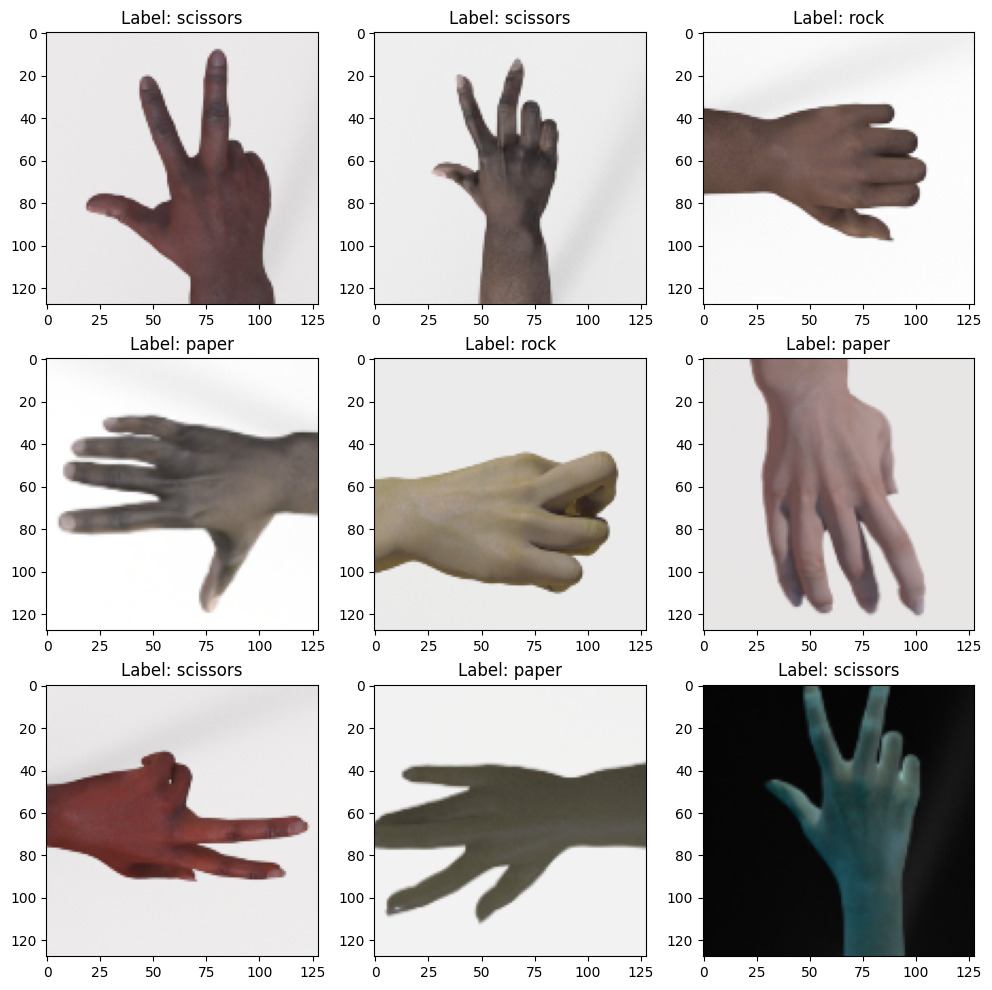

In [547]:
# Náhled upravených trénovacích dat
preview_dataset(dataset_train_augmented)

## Zamíchání dat a rozdělení na dávky

Cílem je zabránit, aby model extrahoval jakékoliv informace z pořadí nebo seskupení obrázků v datasetu. K dosažení tohoto cíle provedeme náhodné zamíchání trénovacích příkladů. Pro optimalizaci procesu učení a snížení nároků na paměť navíc rozdělíme trénovací množinu do dávek.

In [548]:
BATCH_SIZE = 800

dataset_train_augmented_shuffled = dataset_train_augmented.shuffle(
    buffer_size=NUM_TRAIN_EXAMPLES
)

dataset_train_augmented_shuffled = dataset_train_augmented.batch(
    batch_size=BATCH_SIZE
)

# Přednačtení dat do paměti při fázi učení (optimalizace)
dataset_train_augmented_shuffled = dataset_train_augmented_shuffled.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)

dataset_test_shuffled = dataset_test.batch(BATCH_SIZE)

In [549]:
print(dataset_train_augmented_shuffled)
print(dataset_test_shuffled)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


## Vytvoření modelu

### Stažení MobileNetV2 modelu

MobileNetV2 byl naučen na 1000 různých třídách a pro účely této aplikace jsou potřeba jenom 3, lze vynechat vrchní vrstvu sítě pomocí `include_top=False`.

`MobileV2` [MobileV2 Keras Documentation](https://keras.io/api/applications/mobilenet/#mobilenetv2-function)

In [550]:
base_model = tf.keras.applications.MobileNetV2(
  input_shape=INPUT_IMG_SHAPE,
  include_top=False,
  weights='imagenet',
  pooling='avg'
)

In [551]:
# Cílem není přetrénování modelu a tedy změna vah, ale pouze jeho použití pro predikci
base_model.trainable = False

In [552]:
# Výpis základní charakteristiky modelu MobileNetV2
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_14[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[

In [553]:
# Grafické znázornění modelu
tf.keras.utils.plot_model(
    base_model,
    show_shapes=True,
    show_layer_names=True,
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Vytvoření modelu pro klasifikaci 

In [554]:
# Nový model
model = tf.keras.models.Sequential()

# Přidání vrstvy s MobileNetV2
model.add(base_model)

#  Náhodné vypnutí [50] % neuronů
model.add(tf.keras.layers.Dropout(0.5))

# Vrstva pro klasifikaci
model.add(tf.keras.layers.Dense(
    units=NUM_CLASSES,
    activation=tf.keras.activations.softmax,
    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
))

In [555]:
# Charakteristika vytvořeného modelu
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dropout_13 (Dropout)        (None, 1280)              0         
                                                                 
 dense_13 (Dense)            (None, 3)                 3843      
                                                                 
Total params: 2261827 (8.63 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [556]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Kompilace modelu

In [557]:
# Vypočítání počtu kroků pro trénování a validaci
steps_per_epoch = NUM_TRAIN_EXAMPLES // BATCH_SIZE
validation_steps = NUM_TEST_EXAMPLES // BATCH_SIZE if NUM_TEST_EXAMPLES // BATCH_SIZE else 1

print('steps_per_epoch:', steps_per_epoch)
print('validation_steps:', validation_steps)

steps_per_epoch: 3
validation_steps: 1


In [558]:

base_learning_rate = 0.0001

#optimizer = tf.keras.optimizers.legacy.Adam(lr_schedule)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

## Trénování modelu

In [559]:
# Smazání předchozích checkpointů a logů
!rm -rf tmp/checkpoints
!rm -rf logs

In [560]:
# Vytvoření callbacků pro Tenserboard a předčasné ukončení učení

os.makedirs('logs/fit', exist_ok=True)

tensorboard_log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=tensorboard_log_dir,
    histogram_freq=1
)

os.makedirs('tmp/checkpoints', exist_ok=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tmp/checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
)

# Zastavení trénování pokud se model nezlepšuje
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='val_accuracy'
)

In [561]:
# Nastavení počtu epoch
EPOCHS = 20

In [562]:
# Trénování modelu
training_history = model.fit(
    x=dataset_train_augmented_shuffled.repeat(),
    validation_data=dataset_test_shuffled.repeat(),
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[
        model_checkpoint_callback,
        early_stopping_callback,
        tensorboard_callback
    ],
    verbose=1
)

Epoch 1/20
3/3 [==============================] - ETA: 0s - loss: 1.7537 - accuracy: 0.3696

/opt/homebrew/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 9s 3s/step - loss: 1.7537 - accuracy: 0.3696 - val_loss: 1.1532 - val_accuracy: 0.4785
Epoch 2/20
3/3 [==============================] - 4s 2s/step - loss: 1.2445 - accuracy: 0.4948 - val_loss: 1.0288 - val_accuracy: 0.4866
Epoch 3/20
3/3 [==============================] - 4s 1s/step - loss: 1.1076 - accuracy: 0.5407 - val_loss: 0.9043 - val_accuracy: 0.5269
Epoch 4/20
3/3 [==============================] - 4s 1s/step - loss: 1.0108 - accuracy: 0.5855 - val_loss: 0.7349 - val_accuracy: 0.6747
Epoch 5/20
3/3 [==============================] - 6s 2s/step - loss: 0.8079 - accuracy: 0.6758 - val_loss: 0.7492 - val_accuracy: 0.6909
Epoch 6/20
3/3 [==============================] - 4s 2s/step - loss: 0.7230 - accuracy: 0.7256 - val_loss: 0.7286 - val_accuracy: 0.7016
Epoch 7/20
3/3 [==============================] - 4s 1s/step - loss: 0.6956 - accuracy: 0.7331 - val_loss: 0.6576 - val_accuracy: 0.7204
Epoch 8/20
3/3 [==============================] - 4s

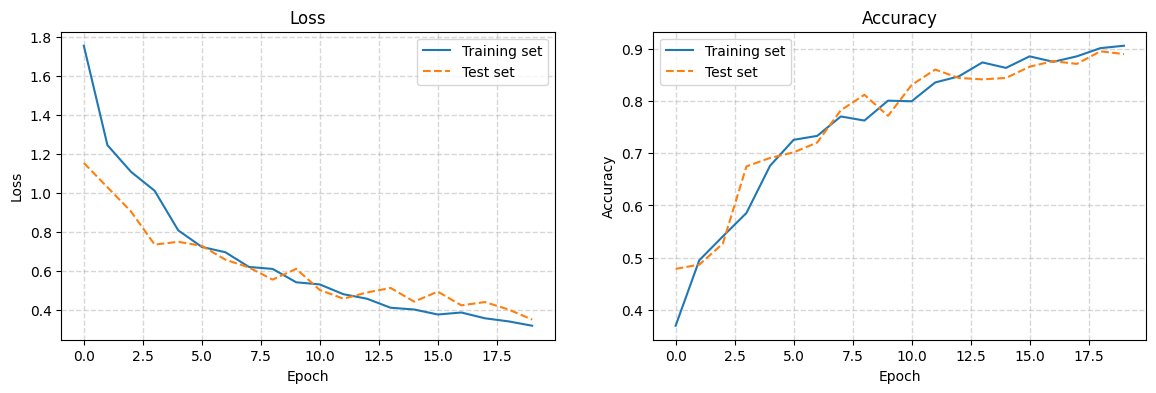

In [563]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

    # acc = history.history['accuracy']
    # val_acc = history.history['val_accuracy']
 
    # loss = history.history['loss']
    # val_loss = history.history['val_loss']

    # plt.figure(figsize=(8, 8))
    # plt.subplot(2, 1, 1)
    # plt.plot(acc, label='Training Accuracy')
    # plt.plot(val_acc, label='Validation Accuracy')
    # plt.legend(loc='lower right')
    # plt.ylabel('Accuracy')
    # plt.ylim([min(plt.ylim()),1])
    # plt.title('Training and Validation Accuracy')
    # 
    # plt.subplot(2, 1, 2)
    # plt.plot(loss, label='Training Loss')
    # plt.plot(val_loss, label='Validation Loss')
    # plt.legend(loc='upper right')
    # plt.ylabel('Cross Entropy')
    # plt.ylim([0,1.0])
    # plt.title('Training and Validation Loss')
    # plt.xlabel('epoch')
    # plt.show()

# Vykreslení trénovací historie
render_training_history(training_history)


## Zobrazení dat v TensorBoard

In [564]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 35771), started 1:16:08 ago. (Use '!kill 35771' to kill it.)

## Zhodnocení modelu

In [565]:
# %%capture
train_loss, train_accuracy = model.evaluate(
    x=dataset_train.batch(BATCH_SIZE).take(NUM_TRAIN_EXAMPLES)
)

test_loss, test_accuracy = model.evaluate(
    x=dataset_test.batch(BATCH_SIZE).take(NUM_TEST_EXAMPLES)
)

1/1 [==============================] - 1s 606ms/step - loss: 0.3509 - accuracy: 0.8898


In [566]:
print('Training loss: ', train_loss)
print('Training accuracy: ', train_accuracy)
print('\n')
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

Training loss:  0.2085588276386261
Training accuracy:  0.9626984000205994


Test loss:  0.3508608043193817
Test accuracy:  0.8897849321365356


## Uložení modelu do formátu .tflite

In [568]:
MODEL_PATH = "./rock_paper_scissors_mobilenet.TFLITE"

# Konvertování modelu do TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Uložení do .tflite souboru
open(MODEL_PATH, 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/j3/pv5hdpmj48d3ntrv2yx7lpxh0000gn/T/tmpyp7rn66h/assets


INFO:tensorflow:Assets written to: /var/folders/j3/pv5hdpmj48d3ntrv2yx7lpxh0000gn/T/tmpyp7rn66h/assets
2023-08-02 13:00:07.481635: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-08-02 13:00:07.481658: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-08-02 13:00:07.481832: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/j3/pv5hdpmj48d3ntrv2yx7lpxh0000gn/T/tmpyp7rn66h
2023-08-02 13:00:07.494408: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-08-02 13:00:07.494425: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/j3/pv5hdpmj48d3ntrv2yx7lpxh0000gn/T/tmpyp7rn66h
2023-08-02 13:00:07.541289: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-08-02 13:00:07.859043: I tensorflow/cc/saved_model/loader.cc:215] Running initialization

8882704